In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Dataset source: https://www.kaggle.com/datasets/frenchbot/portrait-dataset-for-training-gans
### Some helping material: Machine Learning Mastery

## Importing the necessary libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras import backend
from keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
path='/kaggle/input/portrait-dataset-for-training-gans/portraitdataset/r32x32/'

## Getting the images from folder and converting it into tensorflow dataset

In [4]:
import os
from PIL import Image


# Initialize an empty list to store the preprocessed image data
image_data = []

# Loop through the image files in the directory
for filename in os.listdir(path):
    if filename.endswith(".jpg"):
        # Load and resize the image
        image = Image.open(os.path.join(path, filename))
        # Convert the image to numpy array
        image_array = np.array(image)
        # Normalize the image data to the range [-1, 1]
        image_array = (image_array.astype(np.float32) - 127.5) / 127.5
        # Append the preprocessed image to the list
        image_data.append(image_array)

# Convert the list of image arrays to a NumPy array
image_data = np.array(image_data)

# Create a TensorFlow dataset from the image data
dataset = tf.data.Dataset.from_tensor_slices(image_data)

# Shuffle and batch the dataset
batch_size = 32
dataset = dataset.shuffle(len(image_data)).batch(batch_size)

## Visualizing the images

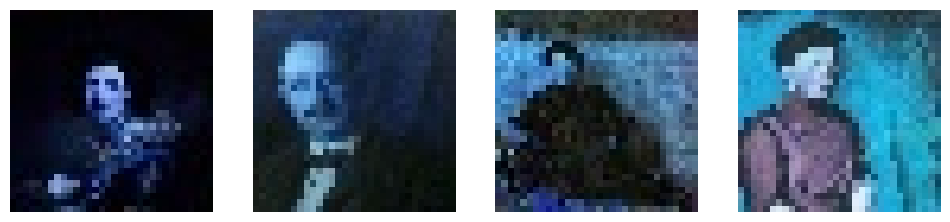

In [5]:
# Visualize a few images from the dataset
num_images_to_show = 4

# Take the first few images from the dataset
sample_images = next(iter(dataset.take(num_images_to_show)))

# Calculate the actual number of images to display
num_images = min(num_images_to_show, sample_images.shape[0])

# Plot the images
fig, axs = plt.subplots(1, num_images, figsize=(12, 3))

for i in range(num_images):
    # Denormalize the image
    image = (sample_images[i] * 0.5) + 0.5
    # Convert to PIL Image format
    image = tf.cast(image * 255, tf.uint8)
    image = tf.keras.preprocessing.image.array_to_img(image)
    axs[i].imshow(image)
    axs[i].axis('off')

plt.show()


## Checking the shape of images

In [6]:
images_batch = next(iter(dataset))
images_np = images_batch.numpy()
images_np.shape

(32, 32, 32, 3)

## Generating the real samples

In [7]:
def gen_real_samples(dataset,n_samples):
    indices=np.random.randint(0,dataset.shape[0],n_samples)
    x_train= dataset[indices]
    y=np.ones((n_samples,1))
    return x_train,y

## Getting vectors from latent space

In [8]:
def get_latent_vector(n_samples,dimension):
    points=np.random.randn(n_samples*dimension)
    points=points.reshape(n_samples,dimension)
    return points

## Generating the fake samples

In [9]:
def gen_fake_samples(gen_model, n_samples, latent_dim): 
    x_input = get_latent_vector(n_samples,latent_dim)
    X = gen_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

## Discriminator Model for classification

In [10]:
def discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Generator Model for generating fake images

In [11]:
def generator(latent_dim):
    model = Sequential()
    nodes = 256 * 4 * 4
    model.add(Dense(nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

## GAN Model 

In [12]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,loss='binary_crossentropy')
    return model

## Defining plots and showing images

In [13]:
def show_image(examples, n):
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        ax.imshow(examples[i, :, :, 0], cmap='gray_r')

    plt.tight_layout()
    plt.show()

## Method used for evaluation

In [14]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100): 
    X_real, y_real = gen_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = gen_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Discriminator accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_%03d.h5' % (epoch + 1)
    g_model.save(filename)

## Method used for training 

In [36]:
def train(gen_model, disc_model, gan_model, dataset, latent_dim=100, n_epochs=20, n_batch=64):
    bat_per_epo = int(15000 / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            x_data=next(iter(dataset))
            x_data=x_data.numpy()
            X_real, y_real = gen_real_samples(x_data, half_batch)
            d_loss_1, _ = disc_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = gen_fake_samples(gen_model,half_batch, latent_dim)
            d_loss_2, _ = disc_model.train_on_batch(X_fake, y_fake)
            X_gan = get_latent_vector(n_batch,latent_dim)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>Epoch: %d, Batch: %d/%d,Disc_real_loss=%.3f ,Disc_fake_loss=%.3f, GAN_Loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss_1,d_loss_2, g_loss))
        if (i+1) % 100 == 0:
            summarize_performance(i, gen_model, disc_model, dataset, latent_dim)


## Models

In [22]:
disc_model=discriminator()
gen_model=generator(100) #where 100 is latent_dim
gan_model=gan(gen_model,disc_model)

## Training of GAN

In [39]:
train(gen_model,disc_model,gan_model,dataset)

1/1 [==============================] - 0s 19ms/step
>Epoch: 1, Batch: 1/234,Disc_real_loss=0.293 ,Disc_fake_loss=0.412, GAN_Loss=1.645
1/1 [==============================] - 0s 18ms/step
>Epoch: 1, Batch: 2/234,Disc_real_loss=0.296 ,Disc_fake_loss=0.310, GAN_Loss=1.701
1/1 [==============================] - 0s 19ms/step
>Epoch: 1, Batch: 3/234,Disc_real_loss=0.361 ,Disc_fake_loss=0.295, GAN_Loss=1.684
1/1 [==============================] - 0s 17ms/step
>Epoch: 1, Batch: 4/234,Disc_real_loss=0.273 ,Disc_fake_loss=0.348, GAN_Loss=1.809
1/1 [==============================] - 0s 17ms/step
>Epoch: 1, Batch: 5/234,Disc_real_loss=0.594 ,Disc_fake_loss=0.467, GAN_Loss=1.705
1/1 [==============================] - 0s 18ms/step
>Epoch: 1, Batch: 6/234,Disc_real_loss=0.627 ,Disc_fake_loss=0.331, GAN_Loss=1.633
1/1 [==============================] - 0s 18ms/step
>Epoch: 1, Batch: 7/234,Disc_real_loss=0.439 ,Disc_fake_loss=0.387, GAN_Loss=1.519
1/1 [==============================] - 0s 17ms/step
>Ep

## Generating new images

1/1 [==============================] - 0s 25ms/step


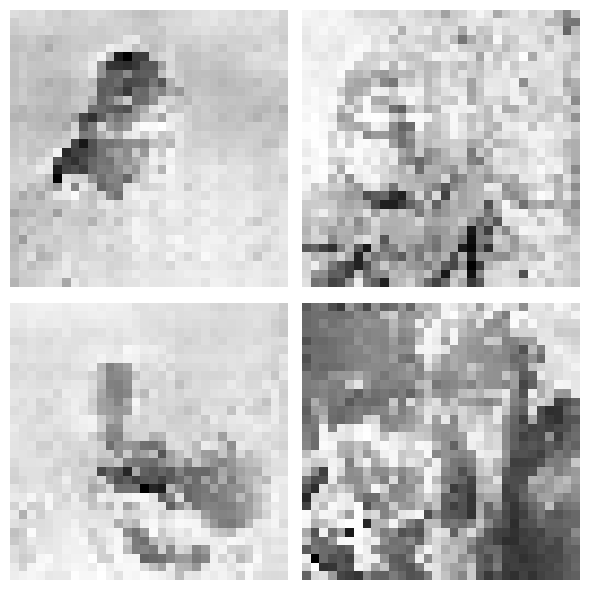

In [42]:
latent_points= get_latent_vector(10, 100)
X  = gen_model.predict(latent_points)
X = (X + 1) / 2.0
show_image(X, 2)

## Saving the model

In [43]:
gen_model.save('potrait_gen.h5')
disc_model.save('potrait_disc.h5')
gan_model.save('potrait_gan.h5')

# Remarks: 
## This model is trained on 300 epochs iteratively on saved weights , so overall training epochs are 300. This is just an example project as we all know that GANs require alot of training, but we can see a blurry images in the generation so it can generate good images in the future if we train this for more epochs